# Here we are exploring models of various population control systems I have built to test in the laboratory

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns

import scipy.integrate

## Simple population capping with environmental AHL degradation only

### create the system of equations

In [2]:
def pop_cap_env_deg (species, t, k_c, k_a, k_tox, n_max, d_c, d_a, d_tox):
    """
    equations for population control without sequestration. Implements only basal environmental degradation
    """
    # Unpack species
    n, ahl, tox = species
    
    # Compute dn/dt
    dn_dt = k_c * n * (1 - (n/n_max) ) - d_c * tox * n
    
    # Compute dahl/dt
    dahl_dt = k_a * n - d_a * ahl
    
    # Compute dtox/dt
    dtox_dt = k_tox * ahl - d_tox * tox
    
    # Return the result as a NumPy array
    return np.array([dn_dt, dahl_dt, dtox_dt])

### set init conditions and params

The next cell sets up all the initial parameters. We can see that I set up a variety of AHL degradation rates, that's what I want this figure to explore.

In [3]:
# Number of time points we want for the solutions
n = 1000

# Time points we want for the solution
t = np.linspace(0, 150, n)

# Initial condition
conds_0 = np.array([1, 0, 0])

# Parameters (from methods of doi:10.1038/nature02491)
k_c = 0.897 # (hr^-1) (taken from pH 7.4 of table 1)
k_a = 4.8 * 10**-7 # (nM ml hr^-1) 
k_tox = 5 # (hr^-1)
n_max = 1.16 * 10**9 # (CFU ml^-1)
d_c = 4 * 10**-3 # (nm^-1 * h^-1)

#I want to vary this, the first 0.791 number is what's calculated from the data in You et al population capping
#this number is the passive environmental degradation rate. My system has an active degradation rate that scales
#with the number of cells
d_a = 0.791#0.791 # (hr^-1) #this probably won't be the same in my system, I'll want to back this out from data without aiia

d_a_set = np.linspace(0, 1, 20)


d_tox = 2 # (h^-1)


### run sim

In [4]:
# Integrate ODES

all_results = []
for DA in d_a_set:
    
    # Package parameters into a tuple
    args = (k_c, k_a, k_tox, n_max, d_c, DA, d_tox)
    
    species = scipy.integrate.odeint(pop_cap_env_deg, conds_0, t, args=args)


    all_results.append(species)

## make a plot

[[<matplotlib.lines.Line2D at 0x265047d5508>],

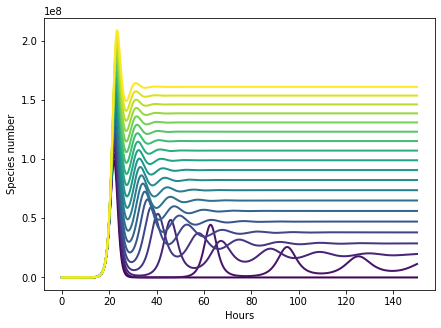

In [5]:
# Set up color palette for this plot
cmap = cm.get_cmap('viridis')
color_distrib = np.linspace(0,1,len(d_a_set))
colors_env = cmap(color_distrib)


# Pluck out values
n_set = []
ahl_set = []
tox_set = []
for s in all_results:
    n_add, ahl_add, tox_add = s.transpose()
    
    n_set.append(n_add)
    ahl_set.append(ahl_add)
    tox_set.append(tox_add)


# Set up plot
f, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Hours')
ax.set_ylabel('Species number')

# Populate plot
[ax.plot(t, val, linewidth=2, color=c, label=deg) for val,deg,c in zip(n_set, d_a_set, colors_env)]

# add legend
# ax.legend(title='ahl deg')

In [6]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'sim_popcap_varyENVdeg.pdf')

By varying environmental population capping, we can change the steady state of a single induction level of population capping. The relationship between induction and steady state increase appears linear, which we will explore below. More degradation decreases overshoot and settling time as you might expect.

let's look at the dependence of steady state value on per cell degradation rate

Text(0, 0.5, 'steady state CFU')

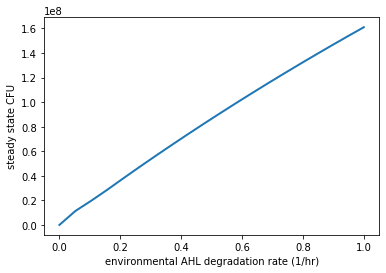

In [7]:
final_vals = [x[-1] for x in n_set]


plt.plot(d_a_set, final_vals, linewidth=2)

plt.xlabel('environmental AHL degradation rate (1/hr)')
plt.ylabel('steady state CFU')

# plt.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'final_vals_varyENVdeg.pdf')

Except at very low degradation rates where ringing is significant and long lasting, the steady state values plotted above vary linearly with degradation rate, at infinite time scales, this would be a perfect line.

# now with a basal environmental degradation and per cell enzymatic degradation

In [8]:
def pop_cap_env_and_enz (species, t, k_c, k_a, k_tox, n_max, d_c, d_a, d_c_a, d_tox):
    """
    equations for population control without sequestration. Has both environmental and per cell enzymatic ahl degradation
    """
    # Unpack species
    n, ahl, tox = species
    
    # Compute dn/dt
    dn_dt = k_c * n * (1 - (n/n_max) ) - d_c * tox * n
    
    # Compute dahl/dt
    dahl_dt = k_a * n - d_a * ahl - d_c_a * n * ahl
    
    # Compute dtox/dt
    dtox_dt = k_tox * ahl - d_tox * tox
    
    # Return the result as a NumPy array
    return np.array([dn_dt, dahl_dt, dtox_dt])

### set init conditions and params

The next cell sets up all the initial parameters. We can see that I set up a variety of enzymatic AHL degradation rates with a constant background environmental ahl deg rate.

In [9]:
# Number of time points we want for the solutions
n = 1000

# Time points we want for the solution
t = np.linspace(0, 150, n)

# Initial condition
conds_0 = np.array([1, 0, 0])

# Parameters (from methods of doi:10.1038/nature02491)
k_c = 0.897 # (hr^-1) (taken from pH 7.4 of table 1)
k_a = 4.8 * 10**-7 # (nM ml hr^-1) 
k_tox = 5 # (hr^-1)
n_max = 1.16 * 10**9 # (CFU ml^-1)
d_c = 4 * 10**-3 # (nm^-1 * h^-1)

#I want to vary this, the first 0.791 number is what's calculated from the data in You et al population capping
#this number is the passive environmental degradation rate. My system has an active degradation rate that scales
#with the number of cells

d_a = 0.791#0.791 # (hr^-1) #this probably won't be the same in my system, I'll want to back this out from data without aiia
#this is the active per cell degradation rate

d_c_a_set = np.linspace(0, 1, 50) * 5*10**-8 #note very small numbers

d_tox = 2 # (h^-1)


### run sim

In [10]:
# Integrate ODES

all_results = []
for DCA in d_c_a_set:
    
    # Package parameters into a tuple
    args = (k_c, k_a, k_tox, n_max, d_c, d_a, DCA, d_tox)
    
    species = scipy.integrate.odeint(pop_cap_env_and_enz, conds_0, t, args=args)


    all_results.append(species)

## make a plot

[[<matplotlib.lines.Line2D at 0x26505010d08>],

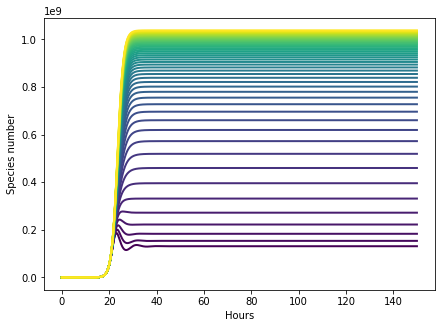

In [11]:
# Set up color palette for this plot
cmap = cm.get_cmap('viridis')
color_distrib = np.linspace(0,1,len(d_c_a_set))
colors_enz = cmap(color_distrib)


# Pluck out values
n_set = []
ahl_set = []
tox_set = []
for s in all_results:
    n_add, ahl_add, tox_add = s.transpose()
    
    n_set.append(n_add)
    ahl_set.append(ahl_add)
    tox_set.append(tox_add)


# Set up plot
f, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Hours')
ax.set_ylabel('Species number')

# Populate plot
[ax.plot(t, val, linewidth=2, color=c, label=deg) for val,deg,c in zip(n_set, d_c_a_set, colors_enz)]

# add legend
# ax.legend(title='ahl deg')

In [12]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'sim_popcap_varyENZdeg.pdf')

Even with a "high" basal environmentl degradation rate as predicted from the Arnold paper in their pH 7.4 medium, addding active per cell degradation on top with aiiA still gives us the ability to tune steady state. That said, the environment sets the low bound for population density, since there is always some amount of degradation of AHL. This is probably the right set of equations to use if you want to fit data.

You can collect basal AHL degradation rates by putting a known concentration of AHL in medium, then incubating it for time and adding reporter cells to aliquots at different time points. Then you can fit out the enzymatic degradation rate per cell.

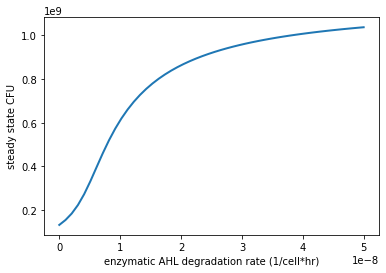

In [15]:
final_vals = [x[-1] for x in n_set]


plt.plot(d_c_a_set, final_vals, linewidth=2)

plt.xlabel('enzymatic AHL degradation rate (1/cell*hr)')
plt.ylabel('steady state CFU')

# plt.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'final_vals_varyENZdeg.pdf')

we can see that when we add per cell enzymatic ahl degradation, we don't get the linear relationship between degradation rate and steady state cfu that you get with passive environmental degradation. This doesn't compromise the function of the circuit, because you can still get whatever steady state CFU value you want (above minimum set by environment). Higher degradation rates are diminishing returns because more deg also allows more cells, which decreases the impact of further increases in degradation rate. So the circuit still works but it's a bit more complicated. Maybe this is actually nice since it's somewhat interesting and shows a non-trivial effect of making degradation cell-intrinsic. I think this is an actual benefit since it removes the environment dependence of circuit function. It seems that when active deg dominates, you don't overshoot or have damped oscillations to steady state.

# Now let's look at handling perturbations

In [14]:
# Number of time points we want for the solutions
n = 1000

tf = 200

# Time points we want for the solution
t1 = np.linspace(0, 100, n)
t2 = np.linspace(100, tf, n)

t = np.append(t1, t2)

In [15]:
# Integrate ODES without enzymatic degradation

all_results_env = []
for DA in d_a_set:
    
    # Package parameters into a tuple
    args = (k_c, k_a, k_tox, n_max, d_c, DA, d_tox)
    
    
    # Package parameters into a tuple
    s1 = scipy.integrate.odeint(pop_cap_env_deg, conds_0, t1, args=args)

    curr_vals = s1[-1]
    curr_vals[0] = curr_vals[0] / 2

    s2 = scipy.integrate.odeint(pop_cap_env_deg, curr_vals, t2, args=args)


    species = np.append(s1, s2, axis=0)
    
    all_results_env.append(species)

In [16]:
# Integrate ODES WITH enzymatic degradation

all_results_enz = []
for DCA in d_c_a_set:
    
    # Package parameters into a tuple
    args = (k_c, k_a, k_tox, n_max, d_c, d_a, DCA, d_tox)
    
    # Package parameters into a tuple
    s1 = scipy.integrate.odeint(pop_cap_env_and_enz, conds_0, t1, args=args)

    curr_vals = s1[-1]
    curr_vals[0] = curr_vals[0] / 2

    s2 = scipy.integrate.odeint(pop_cap_env_and_enz, curr_vals, t2, args=args)


    species = np.append(s1, s2, axis=0)
    
    all_results_enz.append(species)

## make plots

[[<matplotlib.lines.Line2D at 0x2293051eb08>],

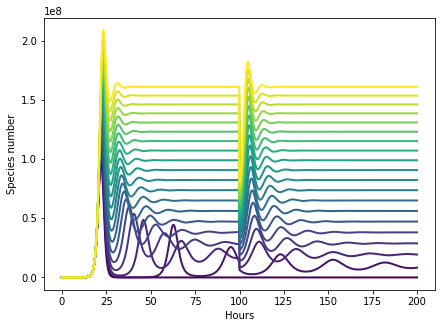

In [17]:
# Pluck out values
n_set_env = []
ahl_set_env = []
tox_set_env = []
for s in all_results_env:
    n_add, ahl_add, tox_add = s.transpose()
    
    n_set_env.append(n_add)
    ahl_set_env.append(ahl_add)
    tox_set_env.append(tox_add)


# Set up plot
f, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Hours')
ax.set_ylabel('Species number')

# Populate plot
[ax.plot(t, val, linewidth=2, color=c, label=deg) for val,deg,c in zip(n_set_env, d_a_set, colors_env)]

# add legend
# ax.legend(title='ahl deg')

In [18]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'perturb_varyENVdeg.pdf')

[[<matplotlib.lines.Line2D at 0x2293159ef48>],

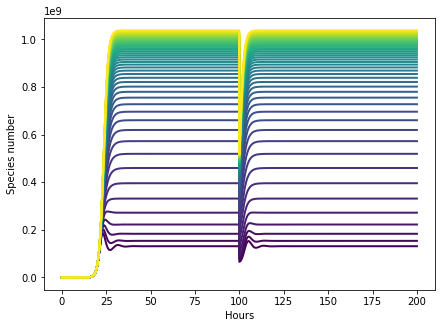

In [19]:
# Pluck out values
n_set_enz = []
ahl_set_enz = []
tox_set_enz = []
for s in all_results_enz:
    n_add, ahl_add, tox_add = s.transpose()
    
    n_set_enz.append(n_add)
    ahl_set_enz.append(ahl_add)
    tox_set_enz.append(tox_add)


# Set up plot
f, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Hours')
ax.set_ylabel('Species number')

# Populate plot
[ax.plot(t, val, linewidth=2, color=c, label=deg) for val,deg,c in zip(n_set_enz, d_c_a_set, colors_enz)]

# add legend
# ax.legend(title='ahl deg')

In [20]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'perturb_varyENZdeg.pdf')

Notes:

the simulation works and recapitulates the simulations done from the arnold paper. I don't know where the non-computed parameter values come from and they don't say where they get them.

with degradation set to 0, the population grows, then collapses, this is much more what i would expect from a simulation. How did we not get this result before? this seems like the only reasonable outcome when AHL is allowed to go to saturation and ccdB is super potent. I feel like seeing this result in simulation before would have clued us into thinking about degradation, damn.

One thing to consider is an alternative perspective in which dead cells don't disappear from the carrying capacity. We could consider a finite resource pool and adjust the growth model to that, we could consider all occupied space to be finite and just not drop the dead cells, we could also consider a distribution of growth rates for cells subject to finite resource limits to model some cells being dead and others being variably compromised due to toxin expression. I think the main consequences here are whether or not the model rejects a perturbation in cell number with no or low degradation. It is possible that with a different growth model, the system doesn't reject a disturbance, we may see this in experiments and should have some possible explanations if we do.

For comparison, I want to see if the steady state values are recapitulated after the perturbation

In [21]:
i_pre = t==t1[-2]
i_end = t == t[-1]

([<matplotlib.axis.XTick at 0x22931699308>,
 <a list of 2 Text xticklabel objects>)

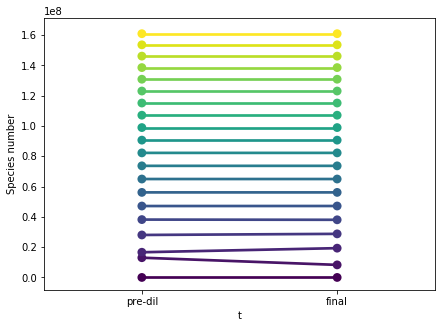

In [22]:
# make a plot for the environmental degradation
f, ax = plt.subplots(figsize=(7,5))

for val,deg,c in zip(n_set_env, d_a_set, colors_env):

    times = [t[i_pre][0], t[i_end][0]]
    data = [val[i_pre][0], val[i_end][0]]

    df = pd.DataFrame({'t' : times, 'd' : data})
    
    sns.pointplot(x='t', y='d', data=df, color=c, ax=ax)
    

ax.set_ylabel('Species number')
plt.xticks(np.array([0, 1]), ['pre-dil', 'final'])

In [23]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'SS_recap_envdeg_stdrsrce.pdf')

([<matplotlib.axis.XTick at 0x22931808048>,
 <a list of 2 Text xticklabel objects>)

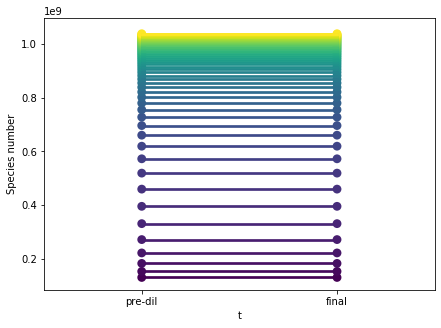

In [24]:
# make a plot for the environmental degradation
f, ax = plt.subplots(figsize=(7,5))

for val,deg,c in zip(n_set_enz, d_c_a_set, colors_enz):

    times = [t[i_pre][0], t[i_end][0]]
    data = [val[i_pre][0], val[i_end][0]]

    df = pd.DataFrame({'t' : times, 'd' : data})
    
    sns.pointplot(x='t', y='d', data=df, color=c, ax=ax)
    
ax.set_ylabel('Species number')
plt.xticks(np.array([0, 1]), ['pre-dil', 'final'])

In [25]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'SS_recap_enzdeg_stdrsrce.pdf')

We can see in both degradation cases that you will always recover your original steady state after a perturbation. In incase this isn't what I see experimentally, I want to explore other ways of modeling this that may not return to steady state.

# Now let's explore what happens if we consider finite resource pools

In [26]:
def pop_cap_finite_env (species, t, k_c, k_a, k_tox, rsrce_tot, d_c, d_a, d_tox, k_rsrce, N_rsrce):
    """
    equations for population control without degradation or sequestration. Now includes a finite resource pool
    """
    # Unpack species
    n, ahl, tox, rsrce = species
    
    # Compute dn/dt. This time we aren't using normal logistic growth. Now it's a Hill fxn of the resource conc
    dn_dt = k_c * n * (1 / (1 + (k_rsrce / rsrce)**N_rsrce)) - d_c * tox * n
    
    # Compute dresource/dt. Resource is normalzed to units of # of cells. This strictly decreases by the increase
    # in number of cells. If cells are dying and not growing (dn_dt < 0), the consumption rate is 0
    if dn_dt <= 0:
        drsrce_dt = 0
    elif dn_dt > 0:
        drsrce_dt = -dn_dt
    
    # Compute dahl/dt
    dahl_dt = k_a * n - d_a * ahl
    
    # Compute dtox/dt
    dtox_dt = k_tox * ahl - d_tox * tox
    
    # Return the result as a NumPy array
    return np.array([dn_dt, dahl_dt, dtox_dt, drsrce_dt])

In [27]:
def pop_cap_finite_env_and_enz (species, t, k_c, k_a, k_tox, rsrce_tot, d_c, d_a, d_c_a, d_tox, k_rsrce, N_rsrce):
    """
    equations for population control without sequestration. Has both environmental and per cell enzymatic ahl degradation
    """
    # Unpack species
    n, ahl, tox, rsrce = species
    
    # Compute dn/dt. This time we aren't using normal logistic growth. Now it's a Hill fxn of the resource conc
    dn_dt = k_c * n * (1 / (1 + (k_rsrce / rsrce)**N_rsrce)) - d_c * tox * n
        
    # Compute dresource/dt. Resource is normalzed to units of # of cells. This strictly decreases by the increase
    # in number of cells. If cells are dying and not growing (dn_dt < 0), the consumption rate is 0
    if dn_dt <= 0:
        drsrce_dt = 0
    elif dn_dt > 0:
        drsrce_dt = -dn_dt
    
    # Compute dahl/dt
    dahl_dt = k_a * n - d_a * ahl - d_c_a * n * ahl
    
    # Compute dtox/dt
    dtox_dt = k_tox * ahl - d_tox * tox
    
    # Return the result as a NumPy array
    return np.array([dn_dt, dahl_dt, dtox_dt, drsrce_dt])

In [28]:
#all params not here aren't changed from their previous instantiation

#the deg parameters we need
d_a = 0.791#0.791 # (hr^-1) #this probably won't be the same in my system, I'll want to back this out from data without aiia

d_a_set = np.linspace(0, 1, 20)

d_c_a_set = np.linspace(0, 1, 50) * 5*10**-8 #note very small numbers


# New parameters (from methods of doi:10.1038/nature02491)

rsrce_tot = 1.16 * 10**9 # (CFU ml^-1) #this is a new one I made up for finite resource modeling

k_rsrce = 0.55 * 10**9 # just chose near the half resource concentration
N_rsrce = 1


# Initial condition
conds_0 = np.array([1, 0, 0, rsrce_tot])


In [29]:
# Integrate ODES without enzymatic degradation

all_results_env_fin = []
for DA in d_a_set:
    
    # Package parameters into a tuple
    args = (k_c, k_a, k_tox, rsrce_tot, d_c, DA, d_tox, k_rsrce, N_rsrce)
    
    
    # Package parameters into a tuple
    s1 = scipy.integrate.odeint(pop_cap_finite_env, conds_0, t1, args=args)

    curr_vals = s1[-1]
    curr_vals[0] = curr_vals[0] / 2

    s2 = scipy.integrate.odeint(pop_cap_finite_env, curr_vals, t2, args=args)


    species = np.append(s1, s2, axis=0)
    
    all_results_env_fin.append(species)

In [30]:
# Integrate ODES WITH enzymatic degradation

all_results_enz_fin = []
for DCA in d_c_a_set:
    
    # Package parameters into a tuple
    args = (k_c, k_a, k_tox, rsrce_tot, d_c, d_a, DCA, d_tox, k_rsrce, N_rsrce)
    
    # Package parameters into a tuple
    s1 = scipy.integrate.odeint(pop_cap_finite_env_and_enz, conds_0, t1, args=args)

    curr_vals = s1[-1]
    curr_vals[0] = curr_vals[0] / 2

    s2 = scipy.integrate.odeint(pop_cap_finite_env_and_enz, curr_vals, t2, args=args)


    species = np.append(s1, s2, axis=0)
    
    all_results_enz_fin.append(species)

[[<matplotlib.lines.Line2D at 0x22931af0e48>],

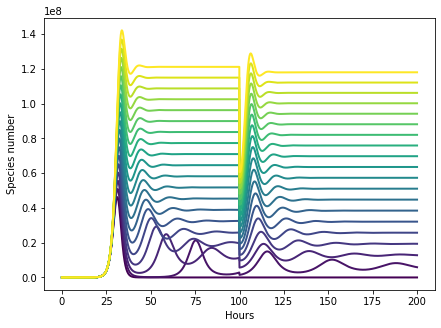

In [31]:
# Pluck out values
n_set_env_fin = []
ahl_set_env_fin = []
tox_set_env_fin = []
rsrce_set_env_fin = []
for s in all_results_env_fin:
    n_add, ahl_add, tox_add, rsrce_add = s.transpose()
    
    n_set_env_fin.append(n_add)
    ahl_set_env_fin.append(ahl_add)
    tox_set_env_fin.append(tox_add)
    rsrce_set_env_fin.append(rsrce_add)


# Set up plot
f, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Hours')
ax.set_ylabel('Species number')

# Populate plot
[ax.plot(t, val, linewidth=2, color=c, label=deg) for val,deg,c in zip(n_set_env_fin, d_a_set, colors_env)]

In [33]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'perturb_envdeg_finrsrce.pdf')

[[<matplotlib.lines.Line2D at 0x229336d1f08>],

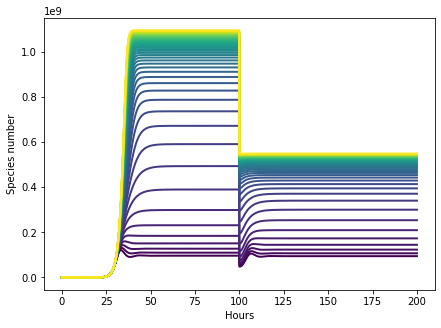

In [34]:
# Pluck out values
n_set_enz_fin = []
ahl_set_enz_fin = []
tox_set_enz_fin = []
rsrce_set_enz_fin = []
for s in all_results_enz_fin:
    n_add, ahl_add, tox_add, rsrce_add = s.transpose()
    
    n_set_enz_fin.append(n_add)
    ahl_set_enz_fin.append(ahl_add)
    tox_set_enz_fin.append(tox_add)
    rsrce_set_enz_fin.append(rsrce_add)


# Set up plot
f, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Hours')
ax.set_ylabel('Species number')

# Populate plot
[ax.plot(t, val, linewidth=2, color=c, label=deg) for val,deg,c in zip(n_set_enz_fin, d_c_a_set, colors_enz)]

In [36]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'perturb_enzdeg_finrsrce.pdf')

When there is really high enzymatic degradation, you allow cells to grow basically to saturation--using up all the growth resources. When that happens, there aren't growth resources left to recover from a perturbation. When degradation is much higher, you can still recover most of your steady state because there are still resources left. Let's see how dramatic this is.

In [37]:
i_pre = t==t1[-2]
i_end = t == t[-1]

([<matplotlib.axis.XTick at 0x22933f9c348>,
 <a list of 2 Text xticklabel objects>)

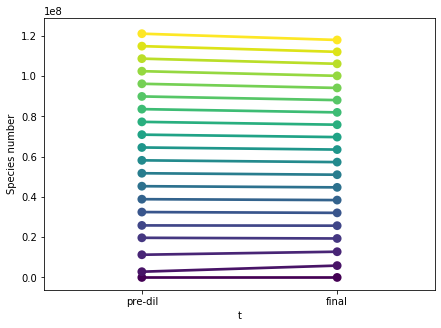

In [38]:
# make a plot for the environmental degradation
f, ax = plt.subplots(figsize=(7,5))

for val,deg,c in zip(n_set_env_fin, d_a_set, colors_env):

    times = [t[i_pre][0], t[i_end][0]]
    data = [val[i_pre][0], val[i_end][0]]

    df = pd.DataFrame({'t' : times, 'd' : data})
    
    sns.pointplot(x='t', y='d', data=df, color=c, ax=ax)
    
ax.set_ylabel('Species number')
plt.xticks(np.array([0, 1]), ['pre-dil', 'final'])

In [39]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'SS_recap_envdeg_finrsrce.pdf')

([<matplotlib.axis.XTick at 0x22933b39f48>,
 <a list of 2 Text xticklabel objects>)

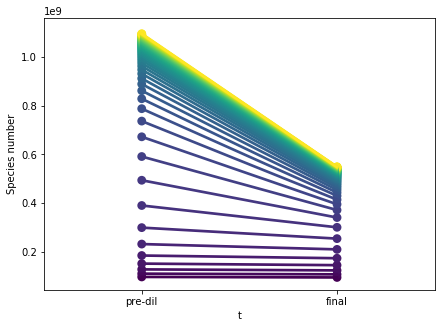

In [40]:
# make a plot for the environmental degradation
f, ax = plt.subplots(figsize=(7,5))

for val,deg,c in zip(n_set_enz_fin, d_c_a_set, colors_enz):

    times = [t[i_pre][0], t[i_end][0]]
    data = [val[i_pre][0], val[i_end][0]]

    df = pd.DataFrame({'t' : times, 'd' : data})
    
    sns.pointplot(x='t', y='d', data=df, color=c, ax=ax)
    
ax.set_ylabel('Species number')
plt.xticks(np.array([0, 1]), ['pre-dil', 'final'])

In [136]:
# f.savefig('C:/Users/geeze/Box/biocircuits/Reed/publications/20200326 pop ctrl paper/' + 'SS_recap_enzdeg_finrsrce.pdf')

# can we program a distribution of toxin levels in the population?

I'm interested in exploring distributions of toxin expression as the mechanism for the capping circuit's function. I think that the steady state population density consists of a bunch of cells with above threshold levels of toxin (dead) and some cells with below threshold levels of toxin that are more or less growth arrested. If this is the case, then the live cells I measure with CFU counts are from the live but arrested pool. I think the shape and mean of the log-normal toxin expression relative to the static threshold of toxin concentration over which cells die determines the population steady state. An experiment with GFP-tagged ccdB, a live/dead cell stain and flow cytometry can identify the threshold and the distribution of toxin expression. I would like to model what happens in this system and test how it responds to perturbations etc. I don't think this is going to be as easy using deterministic ODE models. I will probably need bioscrape to implement stochastic simulations.